In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
from sklearn.base import TransformerMixin

In [2]:
from pydoc import help
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [3]:
raw_data = pd.read_csv('data/cup98lrn.zip', sep = ',',
            error_bad_lines = False, low_memory = False,
            skip_blank_lines = True, na_values = [' '],
            keep_default_na = True, verbose = True)

Tokenization took: 2353.29 ms
Type conversion took: 8224.15 ms
Parser memory cleanup took: 15.41 ms


In [4]:
class Preprocessor:

    @staticmethod
    def fill_nans(dat):
        '''
        Fills in NaNs with either the mean or the most common value.
        '''

        return DataFrameImputer().fit_transform(dat)

class DataFrameImputer(TransformerMixin):
   

    def __init__(self):
        '''
        Impute missing values.
        Columns of dtype object are imputed with the most frequent value in col.
        Columns of other types are imputed with mean of column.
        '''

    def fit(self, X, y = None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index = X.columns)

        return self

    def transform(self, X, y = None):
        return X.fillna(self.fill)

In [5]:

class Performance:

    @staticmethod
    def get_perf(y, y_pred):
        '''
        This method outputs several performance metrics for classification.
        '''

        # Gets Confusion Matrix
        #conf_matrix = metrics.confusion_matrix(y_true = y, y_pred = y_pred)

        # Gets Accuracy
        accuracy = metrics.accuracy_score(y_true = y, y_pred = y_pred)

        # Gets Recall
        recall = metrics.recall_score(y_true = y, y_pred = y_pred)

        # Gets Precision
        precision = metrics.precision_score(y_true = y, y_pred = y_pred)

        # F1
        f1 = metrics.f1_score(y_true = y, y_pred = y_pred)

        return {'accuracy': accuracy, 'recall': recall,
                'precision': precision, 'F1': f1}

In [6]:
import operator

from sklearn.feature_selection import chi2, SelectKBest, VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier


In [7]:
def get_corr_vars(dat, corr_val):
        '''
        Outputs a list of redundant vars that are correlated with others.
        '''

        # Computes correlation
        dat_cor = dat.corr()

        # Cherry picks the lower triangular, excludes diagonal
        dat_cor.loc[:, :] = np.tril(dat_cor, k = -1)

        # Stacks the data.frame
        dat_cor = dat_cor.stack()

        # Get list of correlated vars
        corr_pairs = dat_cor[dat_cor > corr_val].to_dict().keys()
        chosen_vars = [i[0] for i in corr_pairs]
        chosen_vars.extend([i[1] for i in corr_pairs if i[1] not in chosen_vars])

        redundant_vars = [var for var in [
            x for t in corr_pairs for x in t] if var not in chosen_vars]

        return redundant_vars

In [16]:
def get_redundant_vars(target, dat):
    '''
    This method outputs a set of redundant variables.
    '''

    # Some vars that don't seem of good value
    redundant_vars = ['CONTROLN', 'ZIP']

    # Identifies numerical variables with variance zero < 0.1%
    #sel = feature_selection.VarianceThreshold(threshold = 0.001)
    #sel.fit_transform(dat)
    dat_var = dat.var()
    redundant_vars.extend(dat_var.index[dat_var < 0.001])

    # Identifies variables that are too sparse (less than 1%)
    idxs = dat.count() < int(dat.shape[0] * .01)
    redundant_vars.extend(dat.columns[idxs])

    # Identifies variables that are strongly correlated with others
    #redundant_vars.extend(Analyser.get_corr_vars(dat, corr_val = 0.9))

    return redundant_vars


In [9]:
target= 'TARGET_B'

In [11]:
def get_important_vars(target, dat):
        '''
        This method does Feature Selection.
        '''

        # Balances the dataset
        idxs_pos = dat[target] == 1
        pos = dat[idxs_pos]
        neg = dat[dat[target] == 0][1:sum(idxs_pos)]

        # Concatenates pos and neg, it's already shuffled
        sub_dat = pos.append(neg, ignore_index = True)

        # Imputes the data and fills in the missing values
        sub_dat = Preprocessor.fill_nans(sub_dat)

        # Changes categorical vars to a numerical form
        X = pd.get_dummies(sub_dat)

        #### Correlation-based Feature Selection ####

        # Computes correlation between cfg['target'] and the predictors
        target_corr = X.corr()[target].copy()
        target_corr.sort(ascending = False)

        # Sorts and picks the first x features
        # TODO: get optimal x value automatically
        tmp = abs(target_corr).copy()
        tmp.sort(ascending = False)
        important_vars = [tmp.index[0]]
        important_vars.extend(list(tmp.index[2:52])) # removes other target

        #### Variance-based Feature Selection ####

        #sel = VarianceThreshold(threshold = 0.005)
        #X_new = sel.fit_transform(X)

        #### Univariate Feature Selection ####

        #y = X.TARGET_B
        #X = X.drop("TARGET_B", axis = 1)

        #X_new = SelectKBest(chi2, k = 10).fit_transform(X.values, y.values)

        #### Tree-based Feature Selection ####

        #clf = ExtraTreesClassifier()
        #X_new = clf.fit(X.values, y.values).transform(X.values)

        #aux = dict(zip(X.columns, clf.feature_importances_))
        #important_vars = [i[0] for i in sorted(
        #    aux.items(), key = operator.itemgetter(0))]

        return important_vars


In [12]:
#### Exploratory Analysis ####
def expl(data):
    return print(data.shape), print(data.count()), print(data.head()),print(data.columns)
           
expl(raw_data)


(95412, 481)
ODATEDW     95412
OSOURCE     94484
TCODE       95412
STATE       95412
ZIP         95412
MAILCODE     1399
PVASTATE     1458
DOB         95412
NOEXCH      95405
RECINHSE     6703
RECP3        2017
RECPGVG       114
RECSWEEP     1617
MDMAUD      95412
DOMAIN      93096
CLUSTER     93096
AGE         71747
AGEFLAG     65864
HOMEOWNR    73184
CHILD03      1146
CHILD07      1566
CHILD12      1811
CHILD18      2847
NUMCHLD     12386
INCOME      74126
GENDER      92455
WEALTH1     50680
HIT         95412
MBCRAFT     42558
MBGARDEN    42558
            ...  
RAMNT_20     7888
RAMNT_21     9513
RAMNT_22    20873
RAMNT_23     7859
RAMNT_24    17738
RAMNTALL    95412
NGIFTALL    95412
CARDGIFT    95412
MINRAMNT    95412
MINRDATE    95412
MAXRAMNT    95412
MAXRDATE    95412
LASTGIFT    95412
LASTDATE    95412
FISTDATE    95412
NEXTDATE    85439
TIMELAG     85439
AVGGIFT     95412
CONTROLN    95412
TARGET_B    95412
TARGET_D    95412
HPHONE_D    95412
RFA_2R      95412
RFA_2F      954

(None, None, None, None)

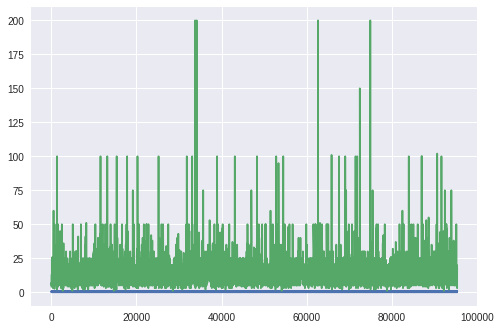

In [14]:
# Distribution of the target variables
plt.plot(raw_data.TARGET_B)
plt.plot(raw_data[raw_data.TARGET_D > 0].TARGET_D)

In [50]:
# Correlation between TARGET_B and the predictors
TARGET_B_corr = raw_data.corr()["TARGET_B"].copy()
TARGET_B_corr.sort(ascending = False)
TARGET_B_corr

/home/siddharth/Documents/Python_virtual/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  app.launch_new_instance()


TARGET_B    1.000000
TARGET_D    0.774232
RFA_2F      0.072311
CARDGIFT    0.054027
NGIFTALL    0.050896
RAMNT_4     0.041755
LASTDATE    0.041158
NUMPROM     0.033161
CARDPROM    0.032467
HV2         0.025607
HV1         0.025012
HVP4        0.024186
HVP3        0.024175
HVP2        0.023514
HVP1        0.022948
DMA         0.022425
HVP5        0.022034
IC5         0.020553
IC4         0.020535
HHAS3       0.020252
HV3         0.020191
HV4         0.020085
RP2         0.019928
HVP6        0.019869
IC2         0.019828
CARDPM12    0.019615
IC3         0.019420
RP1         0.019158
INCOME      0.018688
NUMPRM12    0.018639
              ...   
RAMNT_18   -0.028786
MINRAMNT   -0.031008
ODATEDW    -0.032270
AVGGIFT    -0.032444
RAMNT_19   -0.032590
FISTDATE   -0.032701
RAMNT_21   -0.033230
LASTGIFT   -0.035526
RAMNT_9    -0.036684
RAMNT_24   -0.039781
RAMNT_23   -0.040342
RAMNT_10   -0.042491
RAMNT_14   -0.044768
RAMNT_17   -0.045645
RAMNT_12   -0.047815
RDATE_5    -0.047819
RAMNT_11   -0

In [15]:
# Correlation between TARGET_D and the predictors
TARGET_D_corr = raw_data.corr()["TARGET_D"].copy()
TARGET_D_corr.sort(ascending = False)
TARGET_D_corr

/home/siddharth/Documents/Python_virtual/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  app.launch_new_instance()


TARGET_D    1.000000
TARGET_B    0.774232
RAMNT_4     0.268811
RAMNT_21    0.099339
RAMNT_9     0.090168
RAMNT_14    0.084498
RAMNT_22    0.081324
RAMNT_8     0.081060
RAMNT_12    0.062226
LASTGIFT    0.061678
RAMNT_13    0.059044
RAMNT_11    0.058992
RAMNT_24    0.055679
RAMNT_18    0.049268
RAMNT_7     0.048949
RAMNT_3     0.046038
RAMNT_15    0.045292
RAMNTALL    0.044810
AVGGIFT     0.044299
RAMNT_10    0.044275
RAMNT_23    0.042966
RAMNT_19    0.042596
HV2         0.039860
MAXRAMNT    0.039224
HV1         0.039081
IC5         0.037328
IC4         0.035952
HVP1        0.035650
IC2         0.035496
HVP3        0.035436
              ...   
AGE907     -0.014957
HHAS2      -0.015390
RDATE_13   -0.015653
IC17       -0.016707
OCC10      -0.016983
CLUSTER    -0.017127
OCC8       -0.018126
IC7        -0.020235
OCC13      -0.020906
HHD7       -0.021162
HHD9       -0.021327
GEOCODE    -0.021559
IC16       -0.021655
HHAS4      -0.021963
OCC11      -0.022163
EC2        -0.022298
EC3        -0

In [17]:
# Some statistics about raw_dat's variables
raw_data.describe()

,ODATEDW,TCODE,DOB,CLUSTER,AGE,NUMCHLD,INCOME,WEALTH1,HIT,MBCRAFT,...,FISTDATE,NEXTDATE,TIMELAG,AVGGIFT,CONTROLN,TARGET_B,TARGET_D,HPHONE_D,RFA_2F,CLUSTER2
count,95412.000000,95412.000000,95412.000000,93096.000000,71747.000000,12386.000000,74126.000000,50680.000000,95412.000000,42558.000000,...,95412.000000,85439.000000,85439.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95280.000000
mean,9141.363256,54.223117,2723.602933,27.922553,61.611649,1.527773,3.886248,5.345699,3.321438,0.152075,...,9135.651648,9151.022917,8.093739,13.347786,95778.176959,0.050759,0.793073,0.500618,1.910053,31.533711
std,343.454752,953.844476,2132.241295,14.449652,16.664199,0.806861,1.854960,2.742490,9.306899,0.470023,...,320.394019,294.257260,8.213242,10.769997,55284.596094,0.219506,4.429725,0.500002,1.072749,18.764614
min,8306.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,7211.000000,0.000000,1.285714,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,8801.000000,0.000000,201.000000,15.000000,48.000000,1.000000,2.000000,3.000000,0.000000,0.000000,...,8810.000000,8903.000000,4.000000,8.384615,47910.750000,0.000000,0.000000,0.000000,1.000000,15.000000
50%,9201.000000,1.000000,2610.000000,28.000000,62.000000,1.000000,4.000000,6.000000,0.000000,0.000000,...,9201.000000,9204.000000,6.000000,11.636364,95681.500000,0.000000,0.000000,1.000000,2.000000,32.000000
75%,9501.000000,2.000000,4601.000000,40.000000,75.000000,2.000000,5.000000,8.000000,3.000000,0.000000,...,9409.000000,9409.000000,11.000000,15.477955,143643.500000,0.000000,0.000000,1.000000,3.000000,49.000000
max,9701.000000,72002.000000,9710.000000,53.000000,98.000000,7.000000,7.000000,9.000000,241.000000,6.000000,...,9603.000000,9702.000000,1088.000000,1000.000000,191779.000000,1.000000,200.000000,1.000000,4.000000,62.000000


In [18]:
# Variable distribution

#[1:28] # demographics
#[29:42] # response to other types of mail orders
#[43:55] # overlay data
#[56:74] # donor interests
#[75] # PEP star RFA status
#[76:361] # characteristics of donor neighborhood
#[362:407] # promotion history
#[408:412] # summary variables of promotion history
#[413:456] # giving history
#[457:469] # summary variables of giving history
#[470:473] ## ID & TARGETS
#[474:479] # RFA (recency-frequency-donation amount)
#[480:481] # cluster & geocode

# % of donors
print ('Percentage of donors: %s' % (
    100.0 * sum(raw_data.TARGET_B) / raw_data.shape[0]))

Percentage of donors: 5.07588144049


In [21]:
# This data is quite noisy, high dimensional, with lots of missing values
# and just with 5% of positive cases. Feature selection and preprocessing
# will be vital for good modelling.

#### Preprocessing ####

# Gets some redundant variables based on variance, sparsity & common sense
redundant_vars = get_redundant_vars(target, raw_data)


In [23]:
# Drops redundant cols
dat = raw_data.drop(redundant_vars, axis = 1)

In [24]:
# Imputes the data and fills in the missing values
dat = Preprocessor.fill_nans(dat)

In [25]:
# Shuffles observations
dat.apply(np.random.permutation)

,ODATEDW,OSOURCE,TCODE,STATE,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,RECP3,...,TARGET_D,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2
0,9401,STR,2,ID,B,P,4001,0,X,X,...,0.0,1,L,2,E,X,X,X,20.0,B
1,9601,ENQ,0,NV,B,P,3001,0,X,X,...,0.0,1,L,4,D,X,X,X,33.0,A
2,8601,IMP,1,AZ,B,P,6403,0,X,X,...,0.0,1,L,3,D,X,X,X,54.0,A
3,8901,AGR,2,IA,B,P,2601,0,X,X,...,10.0,0,L,2,G,X,X,X,25.0,B
4,8601,BHG,2,CA,B,P,1810,0,X,X,...,0.0,0,L,1,G,X,X,X,24.0,A
5,9501,IMP,1,CA,B,P,5001,0,X,X,...,0.0,1,L,1,F,X,X,X,41.0,B
6,9201,AML,1,NC,B,P,5701,0,X,X,...,0.0,0,L,3,E,X,X,X,59.0,A
7,9501,TX2,0,FL,B,P,0,0,X,X,...,0.0,1,L,1,F,X,X,X,43.0,C
8,9401,SUF,1,IL,B,P,1805,0,X,X,...,0.0,0,L,4,G,X,X,X,52.0,B
9,8601,KNG,0,MT,B,P,4101,0,X,X,...,0.0,1,L,3,F,X,X,C,1.0,C


In [28]:
# Gets important variables
important_vars = get_important_vars(target, dat)

/home/siddharth/Documents/Python_virtual/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:24: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
/home/siddharth/Documents/Python_virtual/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:29: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


In [29]:
# Changes categorical vars to a numerical form
feats = pd.get_dummies(dat)

In [30]:
# Drops the non-important variables
feats = feats[important_vars]

In [31]:
# Does train/test datasets, 70% and 30% respectively
cut = int(feats.shape[0] * .7)


In [32]:
train = feats[1:cut].drop(['TARGET_B'], axis = 1)
y_train = feats.TARGET_B[1:cut]

test = feats[(cut + 1):-1].drop(['TARGET_B'], axis = 1)
y_test = feats.TARGET_B[(cut + 1):-1]


In [33]:
# Creates a balanced trainset
# In classification, some methods perform better with bal datasets,
# particularly tree-based methods like decision trees and random forests.
pos = train[y_train == 1]
neg = train[y_train == 0][1:pos.shape[0]]
y_train_bal = [1] * pos.shape[0]
y_train_bal.extend([0] * neg.shape[0])
train_bal = pos.append(neg, ignore_index = True)

In [34]:
#### Model Selection ####

# Do cross-validation Grid Search to find the optimal parameters
# TODO

#### Training ####

#### Model 1 | Decision Tree Model ####

print ("Model 1 executing...")

# Training
clf = DecisionTreeClassifier(max_depth = 20) # TODO: should let the tree fully grow
# and then prune it automatically according to an optimal depth
clf = clf.fit(train_bal.values, y_train_bal)

# Testing
y_test_pred = clf.predict(test.values)
y_all_models = y_test_pred.copy()

# Confusion Matrix
print (pd.crosstab(
    y_test, y_test_pred, rownames = ['actual'], colnames = ['preds']))

# Gets performance
perf_model1 = Performance.get_perf(y_test.values, y_test_pred)

Model 1 executing...
preds       0      1
actual              
0       14566  12610
1         704    742


In [35]:
#### Model 2 | Random Forest Model ####

print ("Model 2 executing...")

# Training
clf = ExtraTreesClassifier(n_estimators = 500, verbose = 1,
    bootstrap = True, max_depth = 20, oob_score = True, n_jobs = -1)

#clf = RandomForestClassifier(
#    n_estimators = 500, max_depth = 10, verbose = 1, n_jobs = -1)

clf = clf.fit(train_bal.values, y_train_bal)

# Testing
y_test_pred = clf.predict(test.values)
y_all_models += y_test_pred

# Confusion Matrix
print (pd.crosstab(
    y_test, y_test_pred, rownames = ['actual'], colnames = ['preds']))

# Gets performance
perf_model2 = Performance.get_perf(y_test, y_test_pred)


Model 2 executing...


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.7s finished


preds       0      1
actual              
0       15648  11528
1         632    814


In [36]:
#### Model 3 | Logistic Regression Model ####

print ("Model 3 executing...")

# Training
clf = LogisticRegression(max_iter = 200, verbose = 1)
clf = clf.fit(train_bal.values, y_train_bal)

# Testing
y_test_pred = clf.predict(test.values)
y_all_models += y_test_pred

# Confusion Matrix
print(pd.crosstab(
    y_test, y_test_pred, rownames = ['actual'], colnames = ['preds']))

# Gets performance
perf_model3 = Performance.get_perf(y_test, y_test_pred)

Model 3 executing...
[LibLinear]preds       0      1
actual              
0       16837  10339
1         616    830


In [37]:

#### Model 4 | Ensemble Model (majority vote for model 1, 2 and 3) ####

print ("Model 4 executing...")

# Gets performance for an ensemble of all 3 models
y_test_pred = np.array([0] * len(y_all_models))
y_test_pred[y_all_models > 1] = 1
perf_model_ensemble = Performance.get_perf(y_test, y_test_pred)

# Confusion Matrix
print (pd.crosstab(
    y_test, y_test_pred, rownames = ['actual'], colnames = ['preds']))

Model 4 executing...
preds       0      1
actual              
0       16086  11090
1         622    824


In [38]:
#### Model comparison ####

all_models = {'Decision Trees Model': perf_model1,
              'Random Forest Model': perf_model2,
              'Logistic Regression Model': perf_model3,
              'Ensemble Model': perf_model_ensemble}

perf_all_models = pd.DataFrame([[col1, col2, col3 * 100] for col1, d in
    all_models.items() for col2, col3 in d.items()], index = None,
    columns = ['Model Name', 'Performance Metric', 'Value'])

print (perf_all_models)


                   Model Name Performance Metric      Value
0         Random Forest Model             recall  56.293223
1         Random Forest Model           accuracy  57.515198
2         Random Forest Model          precision   6.595365
3         Random Forest Model                 F1  11.807369
4   Logistic Regression Model             recall  57.399723
5   Logistic Regression Model           accuracy  61.725246
6   Logistic Regression Model          precision   7.431283
7   Logistic Regression Model                 F1  13.158938
8        Decision Trees Model             recall  51.313970
9        Decision Trees Model           accuracy  53.483334
10       Decision Trees Model          precision   5.557220
11       Decision Trees Model                 F1  10.028382
12             Ensemble Model             recall  56.984786
13             Ensemble Model           accuracy  59.080428
14             Ensemble Model          precision   6.916233
15             Ensemble Model           